In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier

In [3]:
data = pd.read_csv('heart.csv')

In [4]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
data.shape

(918, 12)

In [6]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Замечаем, что в датасете нет пропусков, значит над этим нам не придется работать и датасет заполнен полностью.

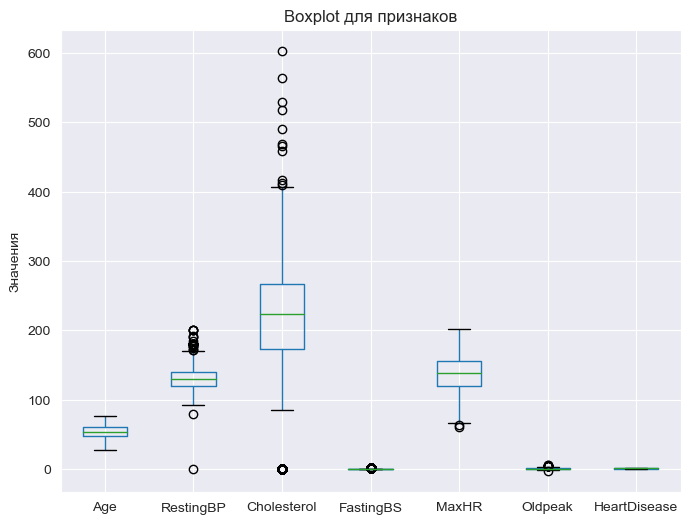

In [7]:
plt.figure(figsize=(8, 6))
data.boxplot()
plt.title('Boxplot для признаков')
plt.ylabel('Значения')
plt.show()

In [8]:
X = pd.get_dummies(data, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

In [9]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [10]:
y = X['HeartDisease']
X = X.drop('HeartDisease', axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Модель логистической регрессии с параметрами по умолчанию

In [12]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184


In [13]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'recall', 'precision', 'f1']
scores = cross_validate(model, X, y, cv=10, scoring=scoring)

for metric, values in scores.items():
    print(f"{metric}: {values.mean():.2f} (std: {values.std():.2f})")

fit_time: 0.10 (std: 0.01)
score_time: 0.01 (std: 0.00)
test_accuracy: 0.86 (std: 0.04)
test_recall: 0.88 (std: 0.09)
test_precision: 0.86 (std: 0.05)
test_f1: 0.87 (std: 0.04)


## GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300 ],  # Количество деревьев
    'max_depth': [3, 7, 10, 20, 30],  # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное число выборок для разделения узла
    'min_samples_leaf': [1, 2, 4]  # Минимальное число выборок в листовом узле
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_

In [15]:
print("Лучшие параметры:", best_params_rf)
print("Лучшие параметры:", best_model_rf)

Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Лучшие параметры: RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)


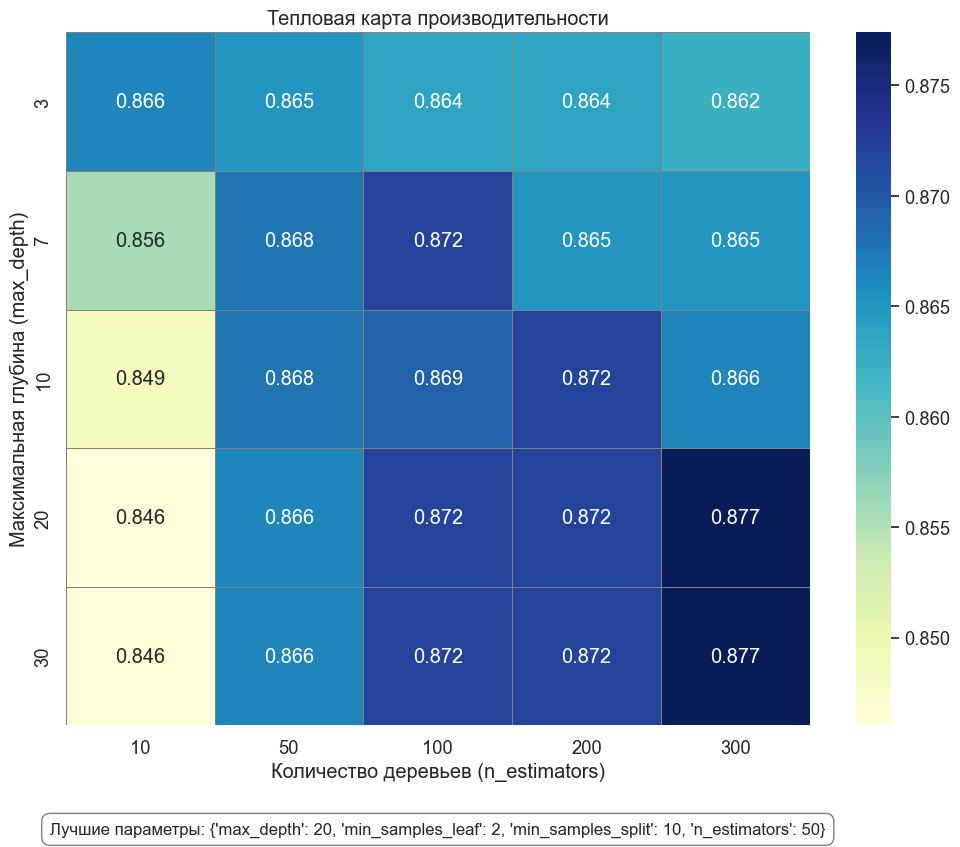

In [16]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.drop_duplicates(subset=['param_max_depth', 'param_n_estimators'])

heatmap_data = results_df.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(12, 9))
sns.set(font_scale=1.2) 
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Тепловая карта производительности")
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel("Максимальная глубина (max_depth)")


best_params = grid_search.best_params_
plt.text(0.5, -0.15, f"Лучшие параметры: {best_params}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
plt.show()

In [17]:
best_model_rf.fit(X_train, y_train)
y_pred = best_model_rf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184


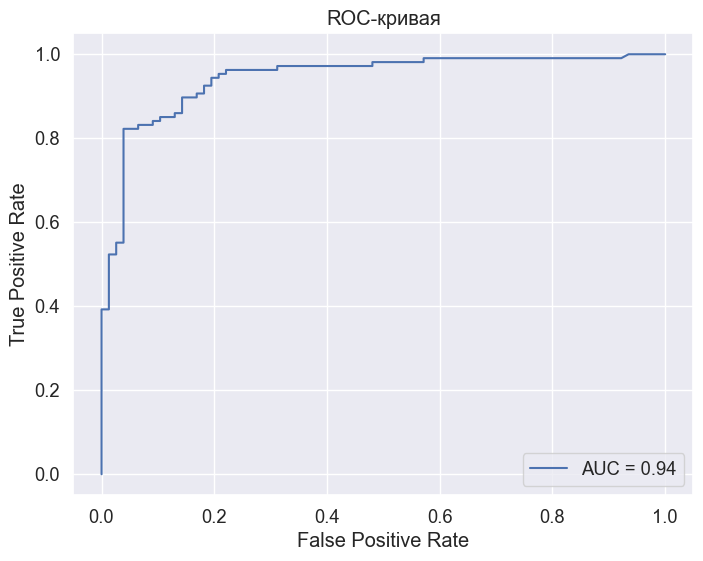

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = best_model_rf.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()


## RandomizedSearchCV

In [19]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier()

param_dist = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,  # Количество случайных комбинаций для проверки
    scoring='accuracy',  # Метрика для оценки качества модели
    cv=5,  # Количество фолдов в кросс-валидации
    n_jobs=-1  # Использовать все доступные ядра процессора
)

random_search.fit(X, y)
print("Лучшие параметры:", random_search.best_params_)
print("Лучшая оценка:", random_search.best_score_)

Лучшие параметры: {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}
Лучшая оценка: 0.8397956759325256


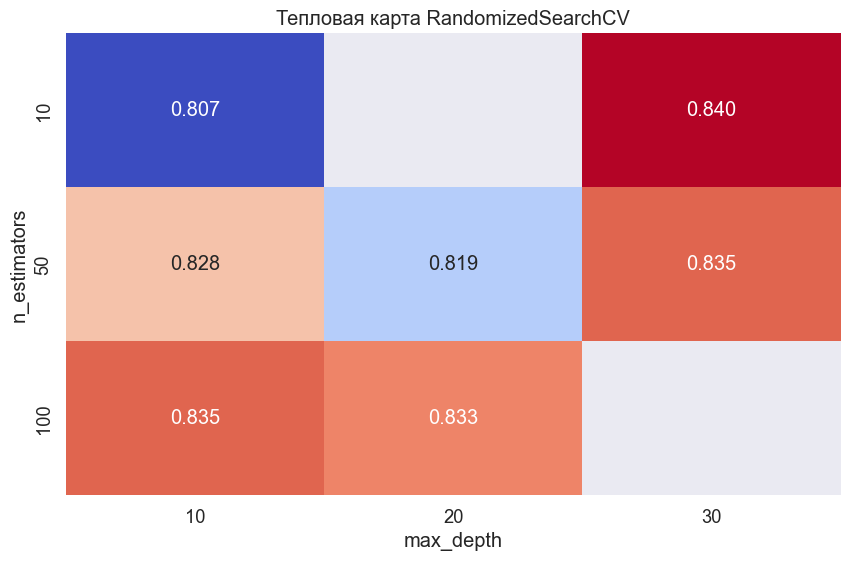

In [20]:
results_df = pd.DataFrame(random_search.cv_results_)

plt.figure(figsize=(10, 6))
pivot_table = results_df.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("Тепловая карта RandomizedSearchCV")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.show()

In [21]:
best_model_rn = random_search.best_estimator_
best_model_rn.fit(X, y)
y_pred = best_model_rn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.97      0.96      0.97       107

    accuracy                           0.96       184
   macro avg       0.96      0.96      0.96       184
weighted avg       0.96      0.96      0.96       184


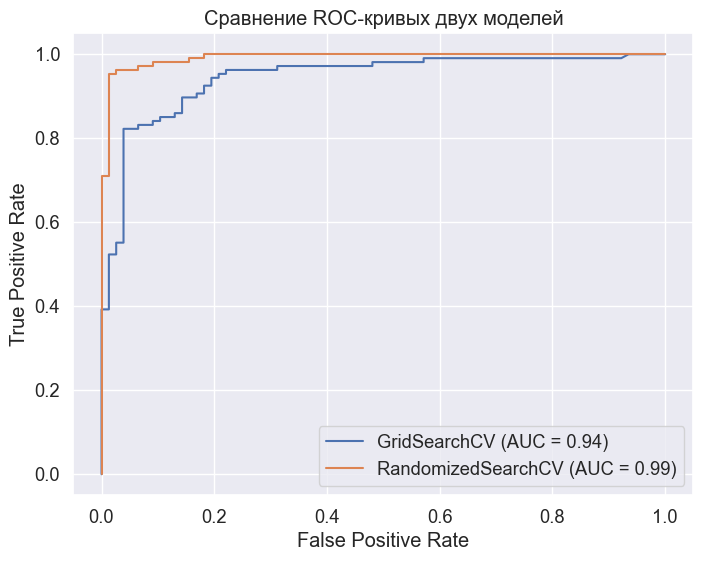

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba2 = best_model_rn.predict_proba(X_test)[:, 1]  # Вероятности класса 1
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_proba2)

roc_auc1 = roc_auc_score(y_test, y_pred_proba)
roc_auc2 = roc_auc_score(y_test, y_pred_proba2)

# Постройте график ROC-кривых для обеих моделей
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'GridSearchCV (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'RandomizedSearchCV (AUC = {roc_auc2:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых двух моделей')
plt.legend()
plt.show()


In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [24]:
svm_params = {'C': [0.1, 1, 10],
              'kernel': ['linear']}
knn_params = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance']}

In [25]:
svm_grid = GridSearchCV(SVC(), svm_params, cv=10)
svm_grid.fit(X, y)
print("SVM с линейным ядром - лучшие параметры:", svm_grid.best_params_)

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=10)
knn_grid.fit(X, y)
print("K-ближайших соседей - лучшие параметры:", knn_grid.best_params_)

SVM с линейным ядром - лучшие параметры: {'C': 1, 'kernel': 'linear'}
K-ближайших соседей - лучшие параметры: {'n_neighbors': 7, 'weights': 'distance'}


In [26]:
svm_random = RandomizedSearchCV(SVC(), svm_params, cv=10, n_iter=10)
svm_random.fit(X, y)
print("SVM с линейным ядром - случайный поиск, лучшие параметры:", svm_random.best_params_)

knn_random = RandomizedSearchCV(KNeighborsClassifier(), knn_params, cv=10, n_iter=10)
knn_random.fit(X, y)
print("K-ближайших соседей - случайный поиск, лучшие параметры:", knn_random.best_params_)

SVM с линейным ядром - случайный поиск, лучшие параметры: {'kernel': 'linear', 'C': 1}
K-ближайших соседей - случайный поиск, лучшие параметры: {'weights': 'distance', 'n_neighbors': 7}


In [27]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'K-Nearest Neighbors'],
    'Best Parameters': [best_params_rf, svm_grid.best_params_, knn_grid.best_params_],
    'Mean CV Score (GridSearchCV)': [grid_search.best_score_, svm_grid.best_score_,  knn_grid.best_score_],
    'Mean CV Score (RandomizedSearchCV)': [random_search.best_score_, svm_random.best_score_, knn_random.best_score_]
})

results.sort_values(by='Mean CV Score (GridSearchCV)', ascending=False, inplace=True)
results


,Model,Best Parameters,Mean CV Score (GridSearchCV),Mean CV Score (RandomizedSearchCV)
0,Random Forest,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",0.878716,0.839796
1,SVM,"{'C': 1, 'kernel': 'linear'}",0.847312,0.847312
2,K-Nearest Neighbors,"{'n_neighbors': 7, 'weights': 'distance'}",0.715564,0.715564


Таким образом, мы сравнили различные модели и нашли их лучшие параметры с помощью GridSearchCV и RandomizedSearchCV. Так как в RandomizedSearchCV значения берутся достаточно случайные, т.е. без определенного отступа, то найденные параментры могут не соответствовать параметрам в GridSearchCV. Лучше всего показал себя Random Forest с 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50. 